In [1]:
import scipy.ndimage
import cv2
import numpy as np
import skimage.color
import skimage.feature
import sklearn.ensemble

%matplotlib inline
import matplotlib.pyplot as plt

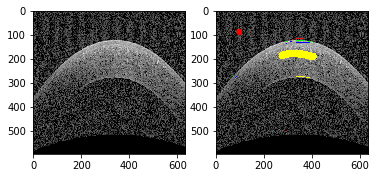

In [2]:

train = cv2.imread("oct2.png")
label = np.load('labels3.npy').squeeze()
train_label = cv2.imread("label_newnew.png")
train_gray = skimage.color.rgb2gray(train)

test = cv2.imread("oct3.png")
#test = cv2.imread("test.png")
test = skimage.color.rgb2gray(test)

train_label = train.copy()


for lbl, color in enumerate([(255,0,0), (0,255,0), (0,0,255), (255,255,0)]):
    mask = label == lbl
    train_label[mask] = color

f = plt.figure()
ax_left = f.add_subplot(121)
ax_right = f.add_subplot(122)
ax_left.imshow(train)
ax_right.imshow(train_label)

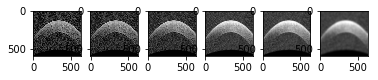

In [176]:
filters = []

f = plt.figure()
sigmas = [0.7, 1, 1.6, 3.5, 5, 10]
for i, sigma in enumerate(sigmas):
    res = scipy.ndimage.gaussian_filter(train_gray, sigma=sigma)
    ax = f.add_subplot(1, len(sigmas), i+1) 
    ax.imshow(res, cmap='gray')
    filters.append(res)

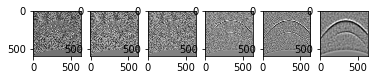

In [177]:
f = plt.figure()
for i, sigma in enumerate(sigmas):
    res = scipy.ndimage.gaussian_laplace(train_gray, sigma=sigma)
    ax = f.add_subplot(1, len(sigmas), i+1) 
    ax.imshow(res, cmap='gray')
    filters.append(res)

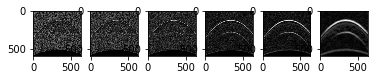

In [178]:
f = plt.figure()
for i, sigma in enumerate(sigmas):
    res = scipy.ndimage.gaussian_gradient_magnitude(train_gray, sigma=sigma)
    ax = f.add_subplot(1, len(sigmas), i+1) 
    ax.imshow(res, cmap='gray')
    filters.append(res)

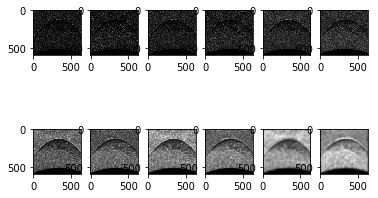

In [179]:
f = plt.figure()
for i, sigma in enumerate(sigmas):
    a,b = skimage.feature.structure_tensor_eigvals(*skimage.feature.structure_tensor(train_gray, sigma))
    ax0 = f.add_subplot(2, len(sigmas), 2*i+1)
    ax1 = f.add_subplot(2, len(sigmas), 2*i+2) 
    ax0.imshow(a, cmap='gray')
    ax1.imshow(b, cmap='gray')
    filters.append(a)
    filters.append(b)

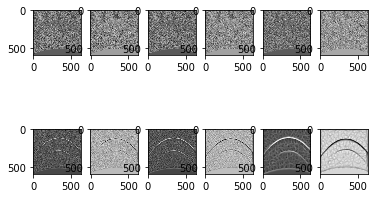

In [180]:
f = plt.figure()
for i, sigma in enumerate(sigmas):
    a,b = skimage.feature.hessian_matrix_eigvals(*skimage.feature.hessian_matrix(train_gray, sigma, order="rc"))
    ax0 = f.add_subplot(2, len(sigmas), 2*i+1)
    ax1 = f.add_subplot(2, len(sigmas), 2*i+2) 
    ax0.imshow(a, cmap='gray')
    ax1.imshow(b, cmap='gray')
    filters.append(a)
    filters.append(b)

In [181]:
filters = np.array(filters)
print(filters.shape)
mask = np.logical_not(np.isnan(label))
train_X = filters[:,mask].T
train_Y = label[np.logical_not(np.isnan(label))]

#train_label = train_label[:,:,0].reshape((-1))
print(train_X.shape)
print(train_Y.shape)


(42, 596, 634)
(6255, 42)
(6255,)


In [182]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=10)
rf.fit(train_X, train_Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [183]:
pred0 = rf.predict_proba(filters.reshape((filters.shape[0], -1)).T)
pred0 = pred0.reshape(train_gray.shape+(-1,))

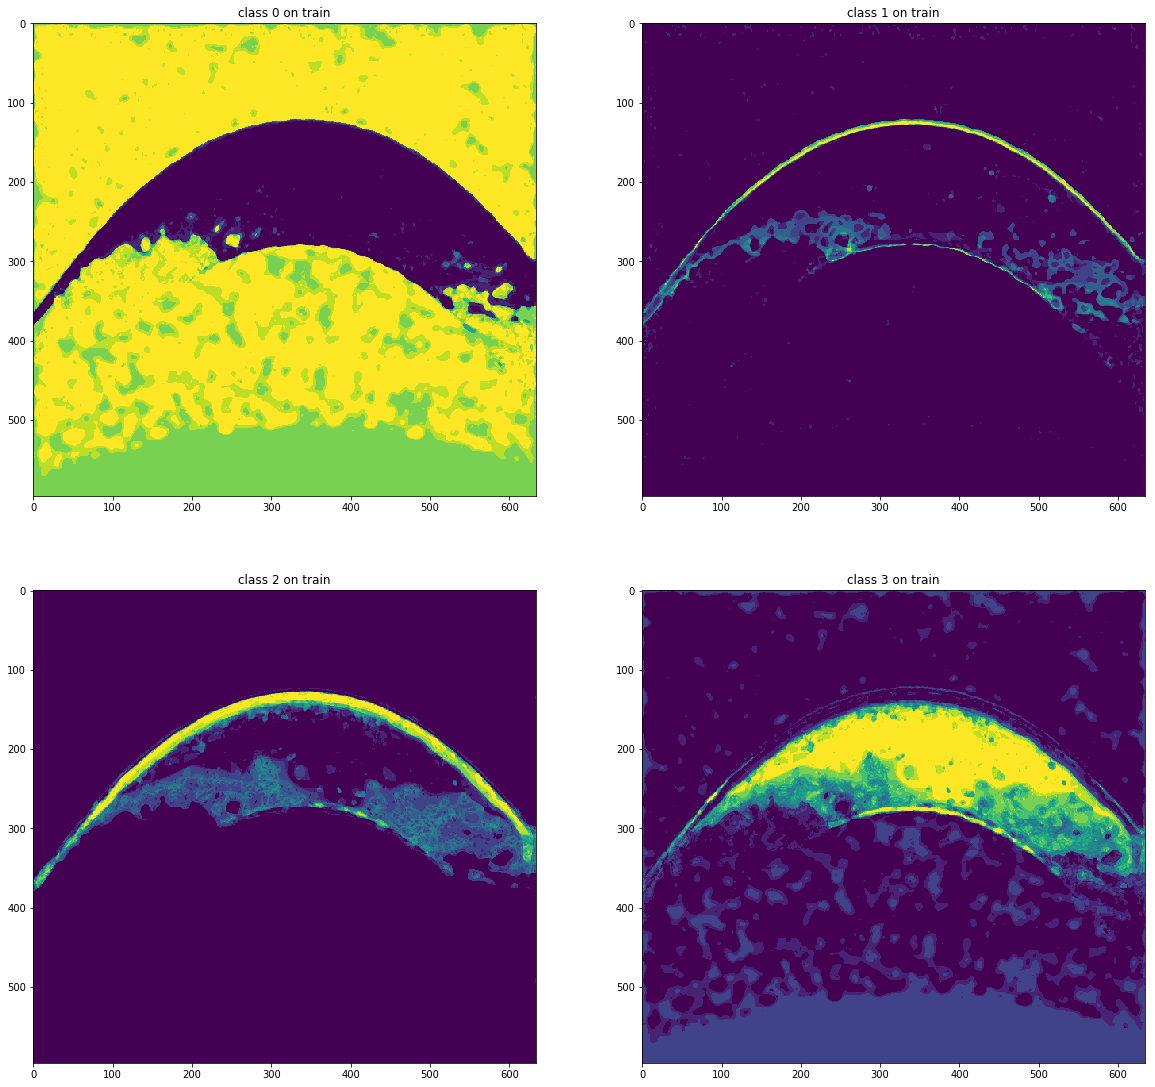

In [184]:
f = plt.figure()
for i_class in range(pred0.shape[-1]):
    ax = f.add_subplot(4, 2, i_class+1)
    ax.imshow(pred0[:,:,i_class])
    ax.set_title(f"class {i_class} on train")
f.set_size_inches(20,40)

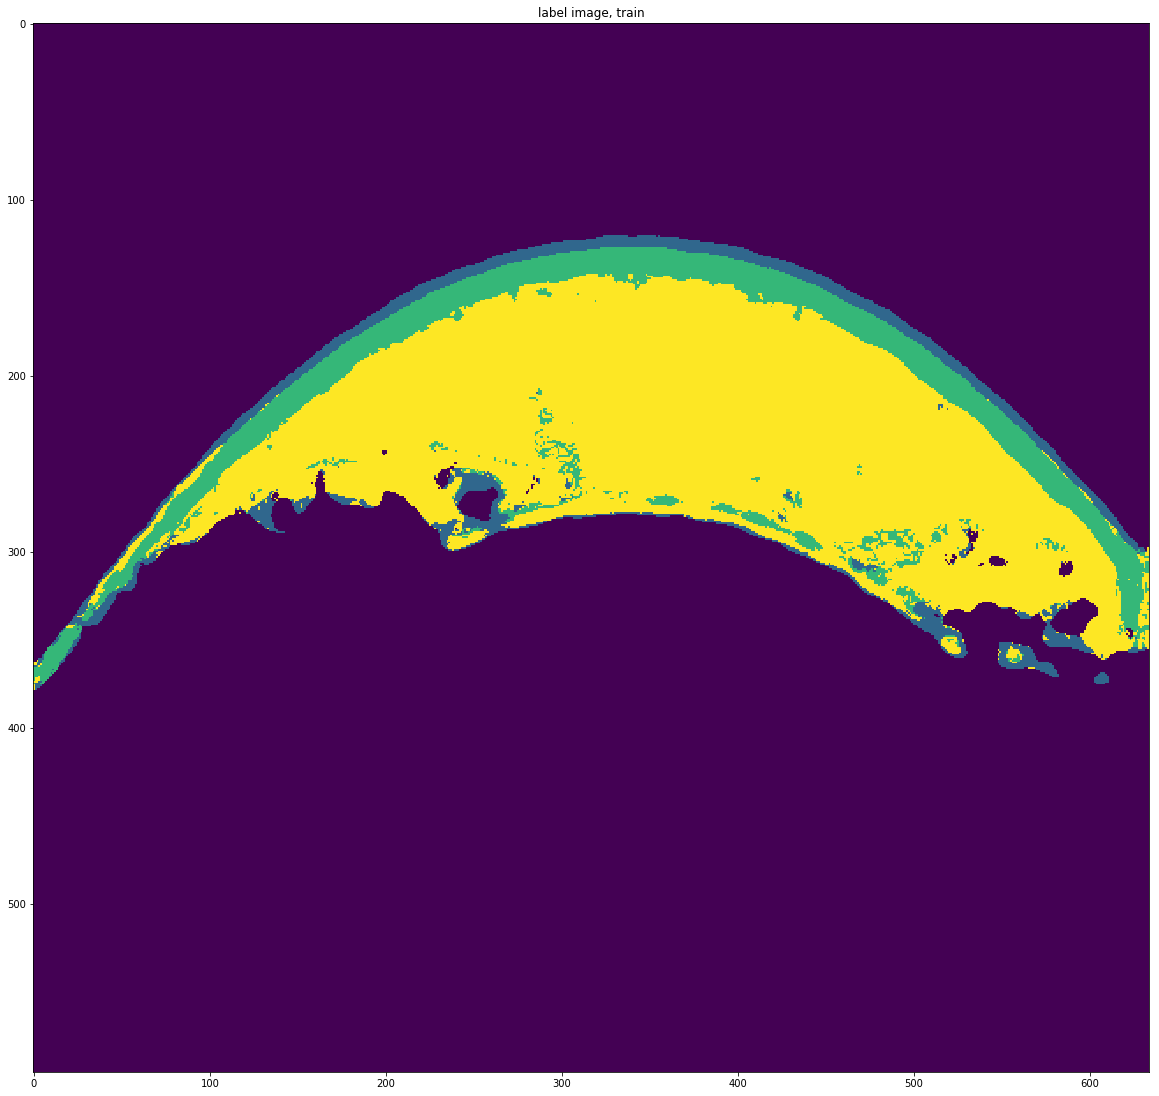

In [185]:
pred_full = np.argmax(pred0, axis=2)
f = plt.figure()
ax = f.add_subplot(111)
ax.imshow(pred_full)
ax.set_title("label image, train")
f.set_size_inches(20,40)

In [186]:
test_filters = []
for i, sigma in enumerate(sigmas):
    res = scipy.ndimage.gaussian_filter(test, sigma=sigma)
    test_filters.append(res)
for i, sigma in enumerate(sigmas):
    res = scipy.ndimage.gaussian_laplace(test, sigma=sigma)
    test_filters.append(res)
for i, sigma in enumerate(sigmas):
    res = scipy.ndimage.gaussian_gradient_magnitude(test, sigma=sigma)
    test_filters.append(res)
for i, sigma in enumerate(sigmas):
    a,b = skimage.feature.structure_tensor_eigvals(*skimage.feature.structure_tensor(test, sigma))
    test_filters.append(a)
    test_filters.append(b)
for i, sigma in enumerate(sigmas):
    a,b = skimage.feature.hessian_matrix_eigvals(*skimage.feature.hessian_matrix(test, sigma, order="rc"))
    test_filters.append(a)
    test_filters.append(b)

In [187]:
test_filters = np.array(test_filters)
pred = rf.predict_proba(test_filters.reshape((test_filters.shape[0], -1)).T)
pred = pred.reshape(test.shape+(-1,))



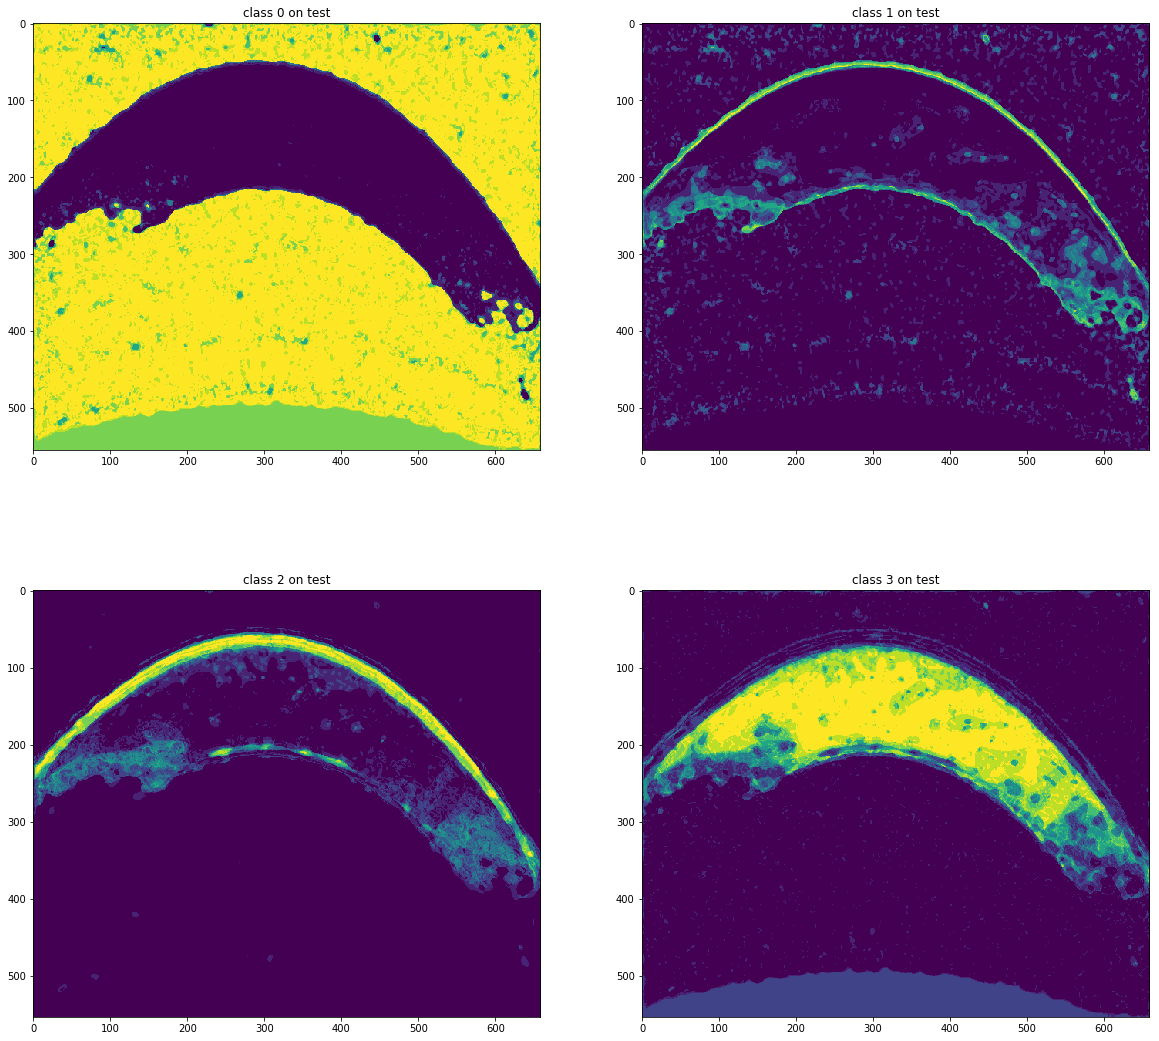

In [188]:
f = plt.figure()
for i_class in range(pred.shape[-1]):
    ax = f.add_subplot(4, 2, i_class+1)
    ax.imshow(pred[:,:,i_class])
    ax.set_title(f"class {i_class} on test")
f.set_size_inches(20,40)

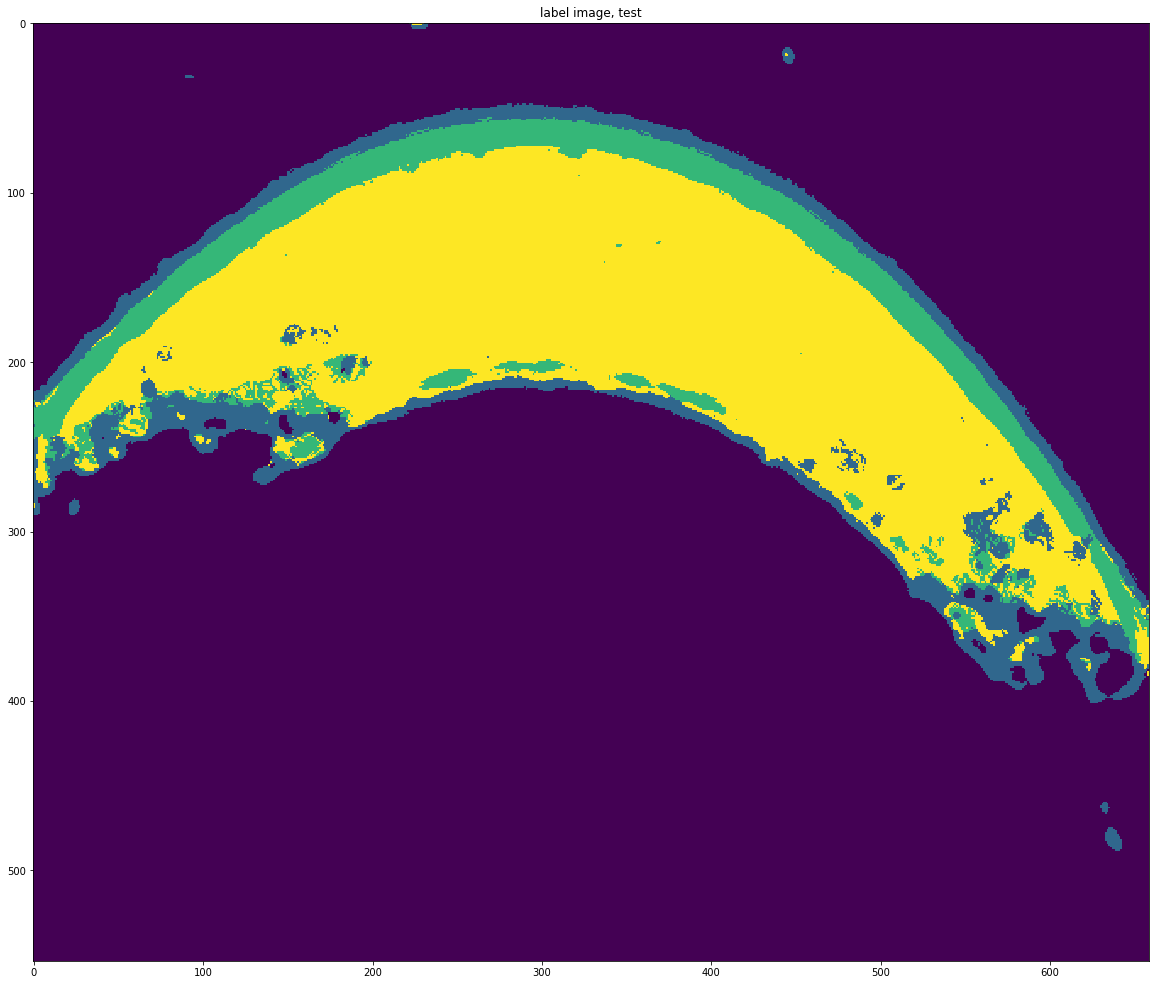

In [189]:
pred_full = np.argmax(pred, axis=2)
f = plt.figure()
ax = f.add_subplot(111)
ax.imshow(pred_full)
ax.set_title("label image, test")
f.set_size_inches(20,40)